In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math, os, glob
import seaborn as sns
import sys
from datetime import datetime, timedelta
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels
import pickle
%matplotlib inline

from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
claims = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/Claims.csv')
# members = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/Members.csv')
# drug_count = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DrugCount.csv')
# lab_count = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LabCount.csv')
# Days_inhospital2 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y2.csv')
# Days_inhospital3 = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/DaysInHospital_Y3.csv')
# Primary_Condescription = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LookupPrimaryConditionGroup.csv')
# Procedure_Condescription = pd.read_csv('C:/Users/Nguyen/AIA/PD exercises/LookupProcedureGroup.csv')

In [4]:
#Xem xét file claims, cleaning data và change type nếu cần thiết
claims.count()

MemberID                 2668990
ProviderID               2652726
Vendor                   2644134
PCP                      2661498
Year                     2668990
Specialty                2660585
PlaceSvc                 2661358
PayDelay                 2668990
LengthOfStay               71598
DSFS                     2616220
PrimaryConditionGroup    2657580
CharlsonIndex            2668990
ProcedureGroup           2665315
SupLOS                   2668990
dtype: int64

In [5]:
claims.dtypes

MemberID                   int64
ProviderID               float64
Vendor                   float64
PCP                      float64
Year                      object
Specialty                 object
PlaceSvc                  object
PayDelay                  object
LengthOfStay              object
DSFS                      object
PrimaryConditionGroup     object
CharlsonIndex             object
ProcedureGroup            object
SupLOS                     int64
dtype: object

In [6]:
claims.head()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.000,172193.000,37796.000,Y1,Surgery,Office,28,NaN,8- 9 months,NEUMENT,0,MED,0
1,97903248,3316066.000,726296.000,5300.000,Y3,Internal,Office,50,NaN,7- 8 months,NEUMENT,1-2,EM,0
2,2759427,2997752.000,140343.000,91972.000,Y3,Internal,Office,14,NaN,0- 1 month,METAB3,0,EM,0
3,73570559,7053364.000,240043.000,70119.000,Y3,Laboratory,Independent Lab,24,NaN,5- 6 months,METAB3,1-2,SCS,0
4,11837054,7557061.000,496247.000,68968.000,Y2,Surgery,Outpatient Hospital,27,NaN,4- 5 months,FXDISLC,1-2,EM,0


In [7]:
# Gọi tên các cột đang dạng categorical ra, và dựa vào bảng sample để quyết định biến đổi các cột như thế nào cho hợp lý
cate = ['object']
cate_columns = list(claims.select_dtypes(include = cate).columns)
print(cate_columns)
# Các biến có thể dùng để groupby: biến thời gian (Year)
# Các biến có số, dùng cách để chuyển về số và agg hoặc các phép tính khác: PayDelay, DSFS, CharlsonIndex
# Các biến còn lại, dùng để groupby: Specialty, PlaceSvc, PrimaryConditionGroup, ProduceGroup

['Year', 'Specialty', 'PlaceSvc', 'PayDelay', 'LengthOfStay', 'DSFS', 'PrimaryConditionGroup', 'CharlsonIndex', 'ProcedureGroup']


In [8]:
#Kiểm tra tính null của các cột khác
total = claims.isnull().sum().sort_values(ascending=False)
percent = (claims.isnull().sum()/claims.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LengthOfStay,2597392,0.973
DSFS,52770,0.020
Vendor,24856,0.009
ProviderID,16264,0.006
PrimaryConditionGroup,11410,0.004
Specialty,8405,0.003
PlaceSvc,7632,0.003
PCP,7492,0.003
ProcedureGroup,3675,0.001
SupLOS,0,0.000


In [9]:
#Xem xét về giá trị của LengthOfStay trong file Claims
claims[claims.LengthOfStay.notnull()]["MemberID"].count()
claims[claims.LengthOfStay.notnull()]["LengthOfStay"].describe()
#Chỉ có 10 giá trị unique của số ngày, hầu hết đều là 1 ngày => Tập train trên noNull của LOS

count     71598
unique       10
top       1 day
freq      56696
Name: LengthOfStay, dtype: object

In [10]:
#Groupby theo giá trị của LengthOfStay
claims.groupby("LengthOfStay").count()
#tập data not null của LengthOfStay (dùng để phân tích). Thay đổi kiểu data hiện tại của LengthOfStay theo dạng ngày để có thể dễ cho các dự đoán nếu có

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
LengthOfStay,,,,,,,,,,,,,
1 day,56696,55550,55519,56275,56696,56531,56446,56696,52855,55916,56696,56481,56696
1- 2 weeks,1143,1053,1053,1083,1143,1134,1143,1143,1054,991,1143,1141,1143
2 days,6485,6406,6401,6423,6485,6445,6448,6485,5394,6072,6485,6441,6485
2- 4 weeks,961,893,893,932,961,955,961,961,901,908,961,945,961
26+ weeks,2,0,0,1,2,2,2,2,2,2,2,2,2
3 days,3246,3217,3214,3228,3246,3246,3236,3246,2789,2991,3246,3223,3246
4 days,1473,1447,1447,1454,1473,1473,1473,1473,1316,1311,1473,1470,1473
4- 8 weeks,903,877,877,891,903,903,902,903,830,846,903,899,903
5 days,510,496,496,502,510,510,509,510,464,422,510,507,510


In [11]:
#BIẾN ĐỔI CÁC BIẾN CATEGORICAL CÓ SỐ THÀNH INT
#LengthOfStay
def LOS_int(s):
    try:
        if 'day' in s:
            return int(s[0])
        if 'weeks' in s and s!= '26+ weeks':
            return int(s[3])*7
        else:
            return 26*7
    except:
        pass

In [12]:
claims['LengthOfStay']= claims['LengthOfStay'].apply(lambda x: LOS_int(x))
claims.groupby('LengthOfStay').count()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
LengthOfStay,,,,,,,,,,,,,
1.000,56696,55550,55519,56275,56696,56531,56446,56696,52855,55916,56696,56481,56696
2.000,6485,6406,6401,6423,6485,6445,6448,6485,5394,6072,6485,6441,6485
3.000,3246,3217,3214,3228,3246,3246,3236,3246,2789,2991,3246,3223,3246
4.000,1473,1447,1447,1454,1473,1473,1473,1473,1316,1311,1473,1470,1473
5.000,510,496,496,502,510,510,509,510,464,422,510,507,510
6.000,179,177,175,179,179,179,179,179,162,119,179,179,179
14.000,1143,1053,1053,1083,1143,1134,1143,1143,1054,991,1143,1141,1143
28.000,961,893,893,932,961,955,961,961,901,908,961,945,961
56.000,903,877,877,891,903,903,902,903,830,846,903,899,903


In [13]:
claims['PayDelay'].value_counts()

0       141451
162+     92592
28       87286
23       85165
29       83899
22       83380
24       82660
30       78784
21       78751
31       73889
35       70537
27       63693
36       60368
17       57018
16       56983
34       54340
37       54026
20       53773
38       48513
15       48435
42       43513
43       40619
44       36581
25       34889
45       32900
32       31582
41       30906
49       29986
50       29832
14       26861
51       26790
39       26245
52       24099
56       23747
18       23668
57       23600
58       21450
26       21126
46       20458
48       19957
59       19750
19       18399
63       18189
33       17294
64       17287
53       16683
65       15282
55       14345
66       14342
70       14300
71       14026
60       12822
40       12543
13       12542
72       12159
10       11883
11       11829
9        11612
77       11217
67       11077
73       11040
62       10685
8        10396
78       10296
12        9455
47        9431
79        

In [14]:
#Có biến 162+ loại bỏ dấu + để thành số
def PayDelay_int(s):
    try:
        if '+' in s:
            return int(s[:-1])
        if type(s) != int:
            return int(s)
    except:
        pass

In [15]:
claims['PayDelay']= claims['PayDelay'].apply(lambda x: PayDelay_int(x))
claims.groupby('PayDelay').count()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
PayDelay,,,,,,,,,,,,,
0,141451,140122,139541,140637,141451,140608,140575,5401,135859,140035,141451,141035,141451
1,94,94,94,94,94,94,94,0,94,93,94,94,94
2,269,269,269,269,269,269,269,0,266,269,269,269,269
3,3195,3195,3195,3195,3195,3195,3195,0,3179,3194,3195,3195,3195
4,4895,4893,4893,4894,4895,4892,4894,1,4857,4894,4895,4895,4895
5,5956,5952,5952,5955,5956,5954,5952,1,5899,5950,5956,5956,5956
6,1271,1271,1271,1271,1271,1271,1271,5,1261,1271,1271,1271,1271
7,4859,4855,4855,4856,4859,4857,4858,7,4823,4853,4859,4859,4859
8,10396,10385,10385,10391,10396,10388,10391,21,10313,10391,10396,10395,10396


['Year', 'Specialty', 'PlaceSvc', 'DSFS', 'PrimaryConditionGroup', 'CharlsonIndex', 'ProcedureGroup']


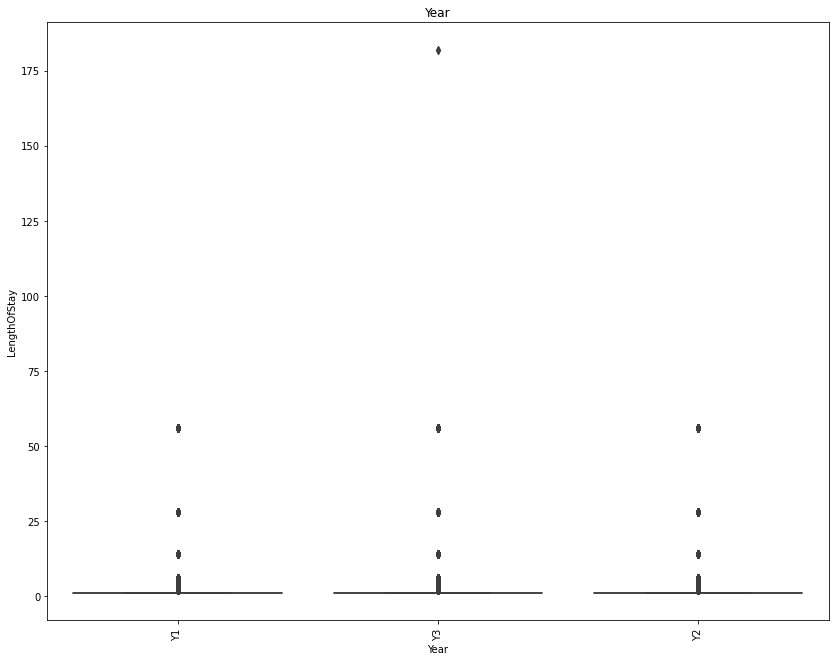

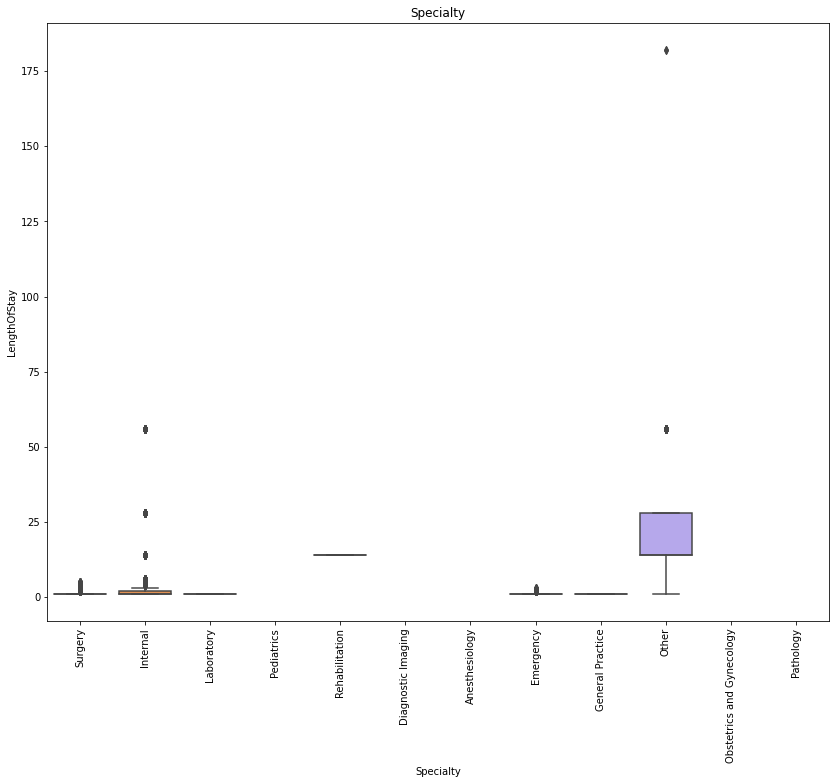

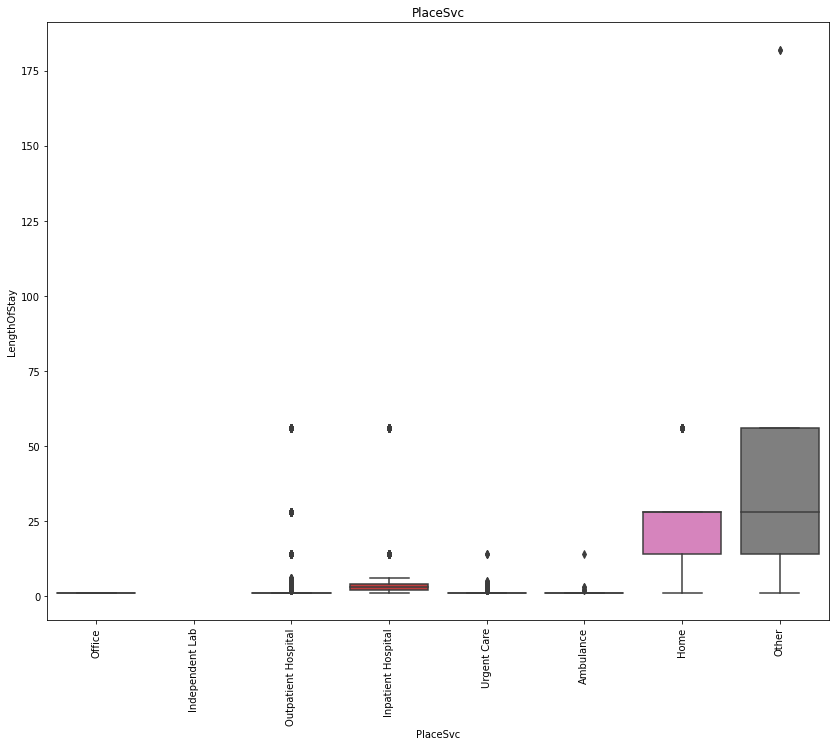

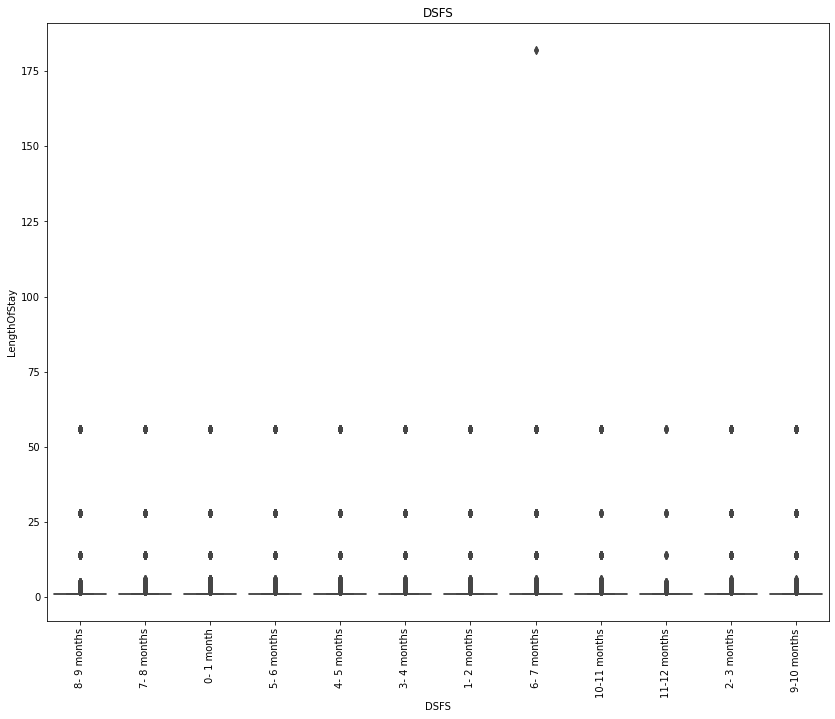

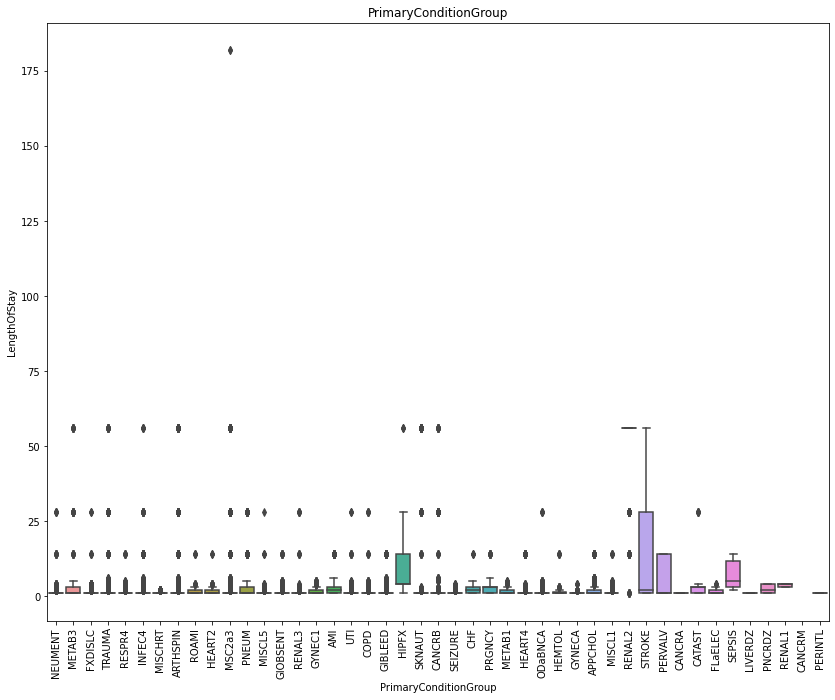

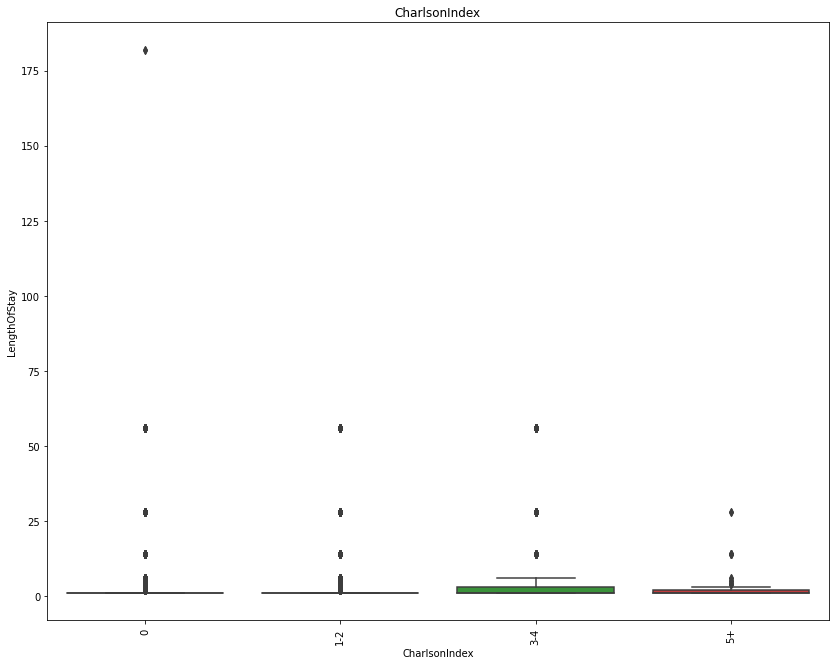

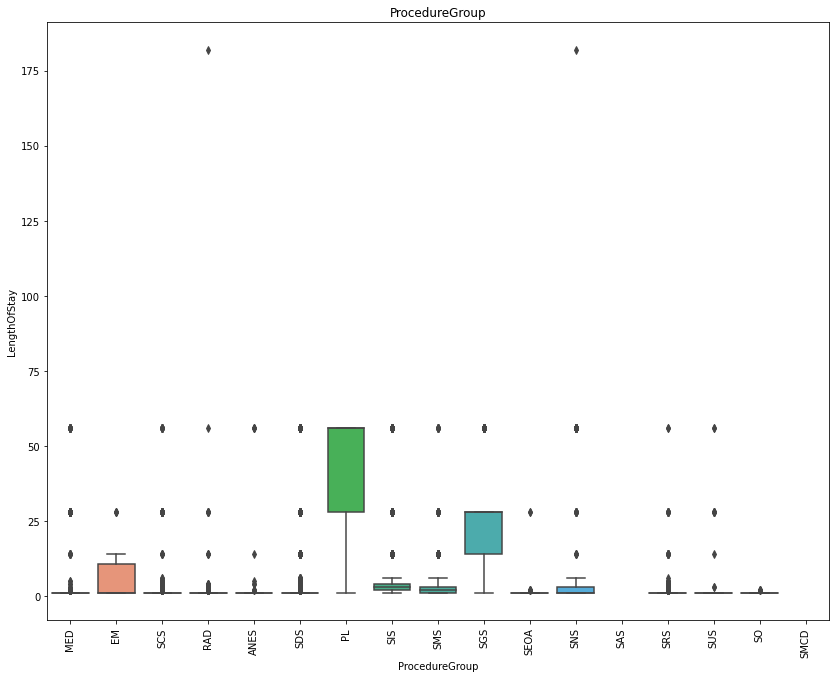

In [15]:
#Trước khi tiếp tục biến các biến categorical thành int, kiểm tra mối quan hệ của chúng với count(MemberID), Sum(LengthOFStay), Sum(PayDelay)
#MemberID
cate_columns2 = list(claims.select_dtypes(include = cate).columns)
print(cate_columns2)

#Load hết tất cả các cột categorical chạy boxplot
for col in cate_columns2:
    plt.figure(figsize = (14, 11))
    sns.boxplot(x=col,y='LengthOfStay', data = claims)
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show
    
# Không tính outlier thì:

#Year: LOS ít biến động qua các năm
#Specialty: chưa rõ ràng, 
#internal có nhiều outlier hơn, và 75% quartile nằm cao hơn các Spec khác.
#Rehabilitation có median chênh nhiều hơn hẳn các Spec khác. Dự kiến là LOS sẽ cao hơn các spec khác

#PlaceSvc: 
#Home và Others là các Place có LOS cao hơn hẳn
#Inpatient hospital có độ biến thiên lớn hơn hẳn các Place khác, do meaning của Place này. Xem xét outlier
#Outpatient hospital hầu hết giống nhau (median = 25th = 75th), nhưng lại outlier nhiều, 
#cho thấy meaning của outpatient nhưng đồng thời phải check xem bệnh nhân bị bao nhiêu bệnh + độ nguy hiểm

#DSFS: chưa rõ ràng

#Primary Condition Group: Có 1 số bệnh thời gian nằm viện biến thiên lớn hơn: 
#STROKE (đột quỵ), HIPFX (gãy xương hông), PERVALV (bệnh về màng và van tim), SEPSIS (giảm huyết áp cấp tính), PRGNCY (sinh nở)
#Outlier của MSC2a3

#CharlsonIndex:
#The Charlson comorbidity index predicts the one-year mortality for a patient who may have a range of comorbid conditions, 
#such as heart disease, AIDS, or cancer (a total of 22 conditions). 
#Each condition is assigned a score of 1, 2, 3, or 6, depending on the risk of dying associated with each one. 
#Scores are summed to provide a total score to predict mortality.
# Score 3-4 thường nằm viện lâu hơn những score khác và có độ variance lớn hơn
# Score 0 vẫn có outlier nằm viện khá lâu, cần được check.

#Procedure:
#Các Procedure biến động hơn: 
#PL - bệnh lý học và test: cần nhiều thời gian chờ kết quả và test tùy bệnh
#SGS - Giải phẫu cơ quan sính sản
#EM - Các dịch vụ tư vấn khám và đánh giá để đưa ra liệu trình điều trị/theo dõi
#SIS - phẫu thuật ngoài da
#SMS - phẫu thuật cơ xương
#SNS - phẫu thuật hệ thần kinh

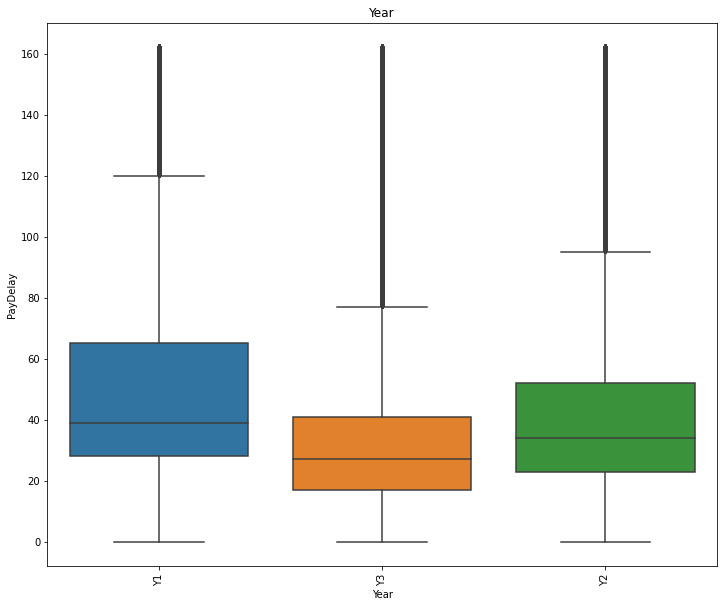

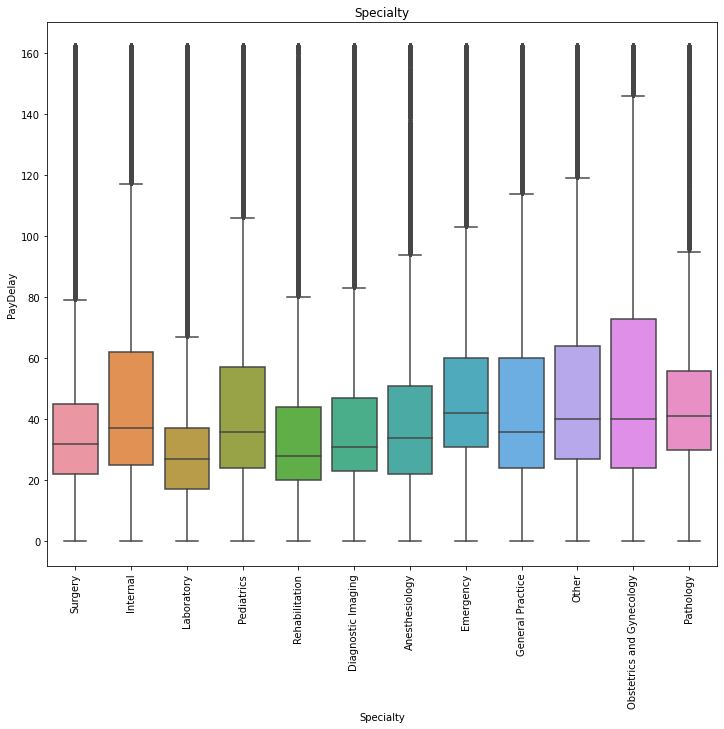

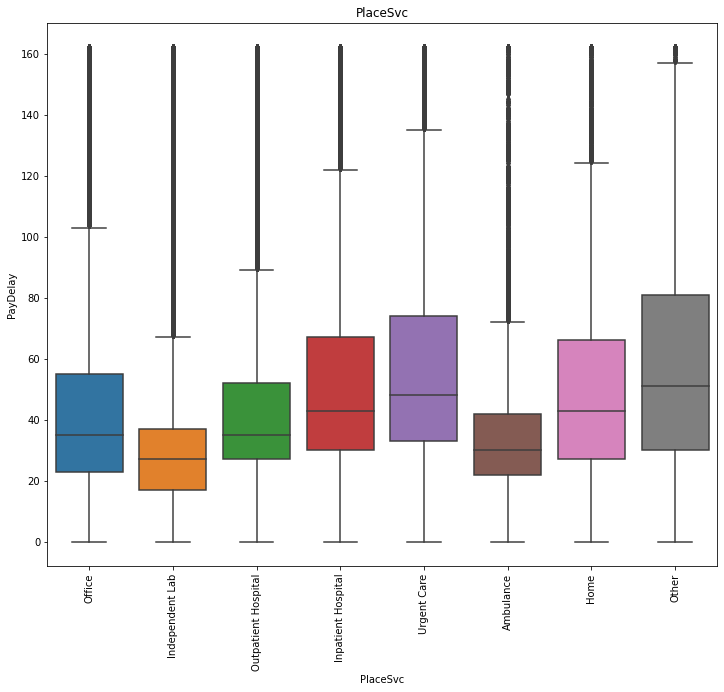

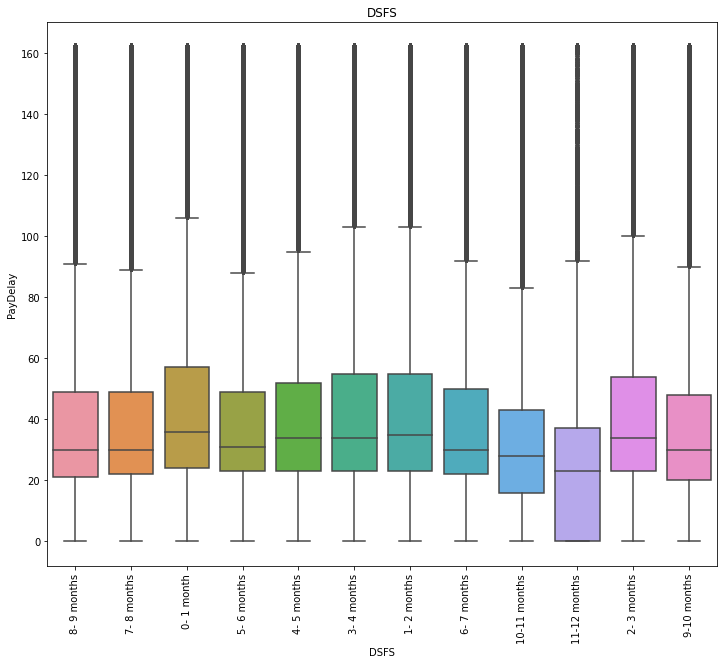

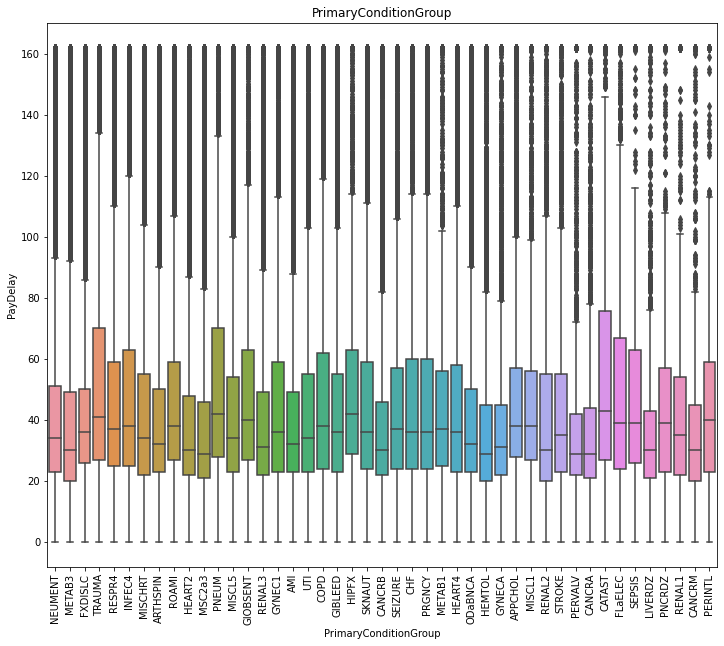

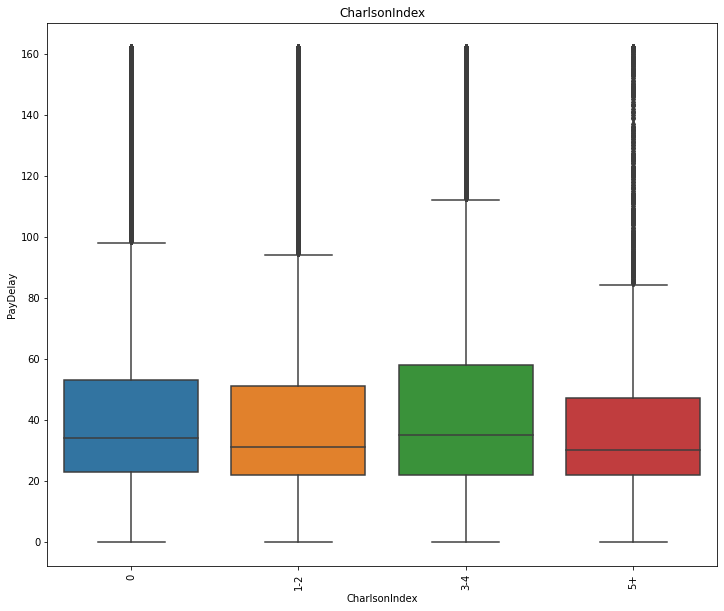

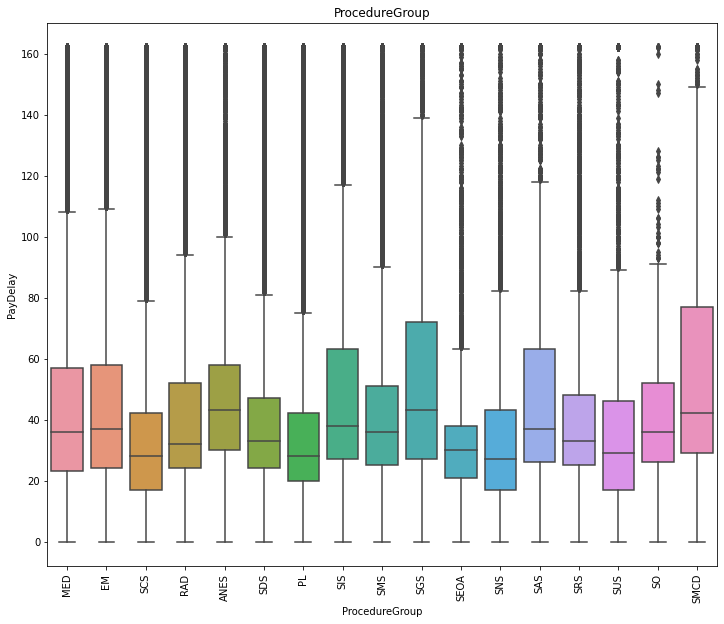

In [30]:
#Load hết tất cả các cột categorical chạy boxplot
for col in cate_columns2:
    plt.figure(figsize = (12, 10))
    sns.boxplot(x=col,y='PayDelay', data = claims)
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show
# Xét theo PayDelay
# Y3 trả sớm hơn Y1 và Y2, nhưng xu hướng là trả sớm dần.

# Về specialty: Internal (điều trị nội khoa), Obstctrics and Gymecology (liên quan đến chuyên khoa sinh sản của nữ) có biến thiên lớn và thời gian trả chậm hơn các chuyên khoa khác
# Có thể do quá trình điều trị kéo dài hoặc chi phí điều trị lớn

# PlaceSvc: Urgent Care (cấp cứu đột xuất k theo lịch) paydelay cao, vì hầu hết sẽ k dự liệu về mặt tài chính trước cho việc emergency => nếu k xét yếu tố bệnh nặng thì có thể mau chóng muốn xuất viện càng sớm càng tốt
# Ambulance và Independent lab khá thấp, variance ít hơn: cấp cứu trên xe cấp cứu thường là unexpected accident và điều trị tại xe cấp cứu nên bệnh nhẹ và dễ thanh toán. 
# Lab thường trả tiền sau khi xét nghiệm, hoặc trả lúc lấy kết quả xét nghiệm nên pay delay thấp => thời gian nằm chờ viện tùy thuộc theo loại bệnh, nhưng theo trend là short term

#DSFS theo xu hướng tự nhiên, giảm dần theo thời gian 

#Condition: các bệnh có biến động cao hơn các condition khác, có median và 75% cao hơn
#TRAUMA (tổn thương vùng đầu, không bao gồm xuất huyết nội)
#PNEUM: (viêm phổi). 
#CATAST (Các bệnh nựng cần chi phí điều trị cao)
#PNEUM và CATAST đều có variance đáng kể so với các bệnh khác nếu so sánh distribution với LOS

#Charlson Index: có sự khác biệt giữa 3-4 so với các mức độ khác, kể cả với PayDelay hay LOS.

#Procedure:
#SGS (phẫu thuật cơ quan sinh sản) và SMCD (phẫu thuật liên quan thai kì) có variance PayDelay lớn + 3/4 + max cũng lớn hơn các cách điều trị khác
#Nếu so với LOS, có sự tương quan giữa việc thực hiện SGS sẽ tăng chi phí + LOS để theo dõi và điều trị

In [34]:
# Xem xét PrimaryConditionGroup thông qua LOS_count & MemberID count (khối lượng các bệnh này trên toàn thể) và LOS_mean (thời gian trung bình nằm viện)
# Chưa tính tương quan với Charlson Index
# Chỉ tính trên tập đã có LengthOfStay

claims_byPCG = claims[claims.LengthOfStay.notnull()].groupby(['PrimaryConditionGroup','Year',]).agg({
    'LengthOfStay': ['sum','mean'],
    'MemberID':['count','nunique']})
claims_byPCG.columns =['LOS_sum','LOS_mean','Member_turn','Unique_mem']
claims_byPCG['% Member_turn'] = claims_byPCG['Member_turn'] / claims_byPCG['Member_turn'].sum() *100
claims_byPCG

#Filter theo: LOS_count > 10000 ngày hoặc LOS_mean > 2 ngày
#2 điều kiện
#cond1 = claim_merge2.LOS_count >= 10000
#cond2 = claim_merge2.LOS_mean >=2
#claim_merge2cond = claim_merge2[~claim_merge2.LOS_count.isin(cond1) | 
           #claim_merge2.LOS_mean.isin(cond2)]
#Xếp giảm dần theo LOS_mean
sort_by_LOS_mean = claims_byPCG.sort_values('LOS_mean',ascending=False)
sort_by_LOS_mean

#Nếu xét theo LOS_mean và các boxplot ở trên, có các trường hợp LOS cao, nhưng biểu hiện do outlier tác động khá lớn: RENAL2, CANCRB, SKNAUT
#STROKE, HIPFX, SEPSIS là các bệnh sẽ nằm thời gian lâu hơn so với các bệnh khác.

LOS_sum  LOS_mean  Member_turn  Unique_mem  \
PrimaryConditionGroup Year                                                
RENAL2                Y3   13612.000    50.602          269          32   
                      Y1   10669.000    50.325          212          31   
                      Y2   11333.000    44.097          257          34   
STROKE                Y3    2322.000    19.513          119          62   
                      Y2    1447.000    12.368          117          79   
HIPFX                 Y2     812.000     9.333           87          41   
SEPSIS                Y2     119.000     9.154           13           9   
HIPFX                 Y1     944.000     8.354          113          55   
                      Y3     536.000     8.121           66          37   
CANCRB                Y2    1267.000     8.070          157         103   
SKNAUT                Y3    2100.000     7.368          285         208   
CANCRB                Y3     987.000     6.493          152          96   
CATAST                Y3     116.000     6.444           18          13   
PERVALV               Y2     115.000     6.389           18          10   
METAB3                Y2    1027.000     6.187          166         106   
CATAST                Y2     127.000     5.773           22          14   
STROKE                Y1     787.000     5.745          137          83   
PNEUM                 Y2    1098.000     5.689          193         136   
METAB3                Y3     977.000     5.680          172         131   
SKNAUT                Y1    1569.000     5.564          282         227   
PERVALV               Y3     123.000     5.348           23           7   
CATAST                Y1      95.000     4.750           20          15   
CANCRB                Y1     818.000     4.648          176         117   
MSC2a3                Y2   10227.000     4.286         2386        1968   
PNEUM                 Y3     593.000     4.236          140         110   
PERVALV               Y1      55.000     4.231           13           9   
SEPSIS                Y1      32.000     4.000            8           6   
RENAL1                Y1       8.000     4.000            2           1   
                      Y3      42.000     3.818           11           6   
MSC2a3                Y3   10475.000     3.638         2879        2347   
SEPSIS                Y3      17.000     3.400            5           5   
MSC2a3                Y1    6270.000     3.297         1902        1644   
RENAL1                Y2      13.000     3.250            4           4   
AMI                   Y3    1234.000     3.197          386         211   
                      Y2    1354.000     3.009          450         251   
PNEUM                 Y1     464.000     2.829          164         125   
ARTHSPIN              Y3    6551.000     2.778         2358        1532   
PNCRDZ                Y2      24.000     2.667            9           8   
CHF                   Y2     165.000     2.661           62          42   
PRGNCY                Y2    2270.000     2.609          870         571   
ARTHSPIN              Y2    5412.000     2.510         2156        1485   
PRGNCY                Y1    2317.000     2.505          925         594   
PNCRDZ                Y1      69.000     2.464           28          20   
METAB3                Y1     284.000     2.427          117         101   
AMI                   Y1    1007.000     2.392          421         259   
PRGNCY                Y3    2025.000     2.360          858         502   
CHF                   Y3     125.000     2.273           55          43   
HEMTOL                Y1     187.000     2.226           84          69   
INFEC4                Y3    1487.000     2.146          693         548   
GIOBSENT              Y3     365.000     2.098          174         146   
INFEC4                Y2    1474.000     2.076          710         572   
SKNAUT                Y2     567.000     2.054        

In [35]:
#Bảng full PrimaryConditionGroup k bỏ null value của LengthOfStay
claims_byPCG = claims.groupby(['PrimaryConditionGroup','Year',]).agg({
    'LengthOfStay': ['sum','mean'],
    'MemberID':['count','nunique']}).reset_index()
claims_byPCG.columns =['PCG','Year','LOS_sum','LOS_mean','Member_turn','Unique_mem']
claims_byPCG['% Member_turn'] = claims_byPCG['Member_turn'] / claims_byPCG['Member_turn'].sum() *100
claims_byPCG


,PCG,Year,LOS_sum,LOS_mean,Member_turn,Unique_mem,% Member_turn
0,AMI,Y1,1007.000,2.392,11611,3335,0.437
1,AMI,Y2,1354.000,3.009,12037,3396,0.453
2,AMI,Y3,1234.000,3.197,11157,3319,0.420
3,APPCHOL,Y1,1296.000,1.677,5865,1494,0.221
4,APPCHOL,Y2,1337.000,1.750,6297,1683,0.237
5,APPCHOL,Y3,1369.000,1.811,5783,1648,0.218
6,ARTHSPIN,Y1,2610.000,1.454,91544,23604,3.445
7,ARTHSPIN,Y2,5412.000,2.510,97747,22907,3.678
8,ARTHSPIN,Y3,6551.000,2.778,98994,22640,3.725
9,CANCRA,Y1,6.000,1.000,1402,277,0.053


In [36]:
# Xem xét CharlsonIndex thông qua LOS_count & MemberID count (khối lượng các bệnh này trên toàn thể) và LOS_mean (thời gian trung bình nằm viện)
claims_byCI = claims[claims.LengthOfStay.notnull()].groupby(['CharlsonIndex','Year',]).agg({
    'LengthOfStay': ['sum','mean'],
    'MemberID':['count','nunique']}).reset_index()
claims_byCI
# Thể hiện Charlson Index ở range 3-4 sẽ có LOS cao hơn. Các bệnh nặng hơn thì mortality rate cao, có thể k có thời gian nằm viện lâu quá cần thiết

CharlsonIndex Year LengthOfStay       MemberID        
                               sum  mean    count nunique
0              0   Y1    22109.000 1.560    14172    9815
1              0   Y2    21702.000 1.628    13329    8916
2              0   Y3    22954.000 1.761    13034    8497
3            1-2   Y1    29276.000 3.654     8012    4923
4            1-2   Y2    38611.000 3.590    10756    6378
5            1-2   Y3    41493.000 3.683    11266    6490
6            3-4   Y1     1116.000 4.309      259     183
7            3-4   Y2     1937.000 6.796      285     203
8            3-4   Y3     3181.000 9.639      330     222
9             5+   Y1       91.000 2.844       32      20
10            5+   Y2      118.000 1.873       63      46
11            5+   Y3      174.000 2.900       60      35

In [37]:
cond = claims.LengthOfStay.notnull()
claims_LOSnotnull = claims[cond]
claims_LOSnotnull_corr = claims_LOSnotnull.corr()
claims_LOSnotnull_corr
# Không có correlation rõ ràng giữa LengthOfStay và PayDelay

,MemberID,ProviderID,Vendor,PCP,PayDelay,LengthOfStay,SupLOS
MemberID,1.000,-0.002,-0.005,0.005,0.000,0.015,-0.006
ProviderID,-0.002,1.000,-0.140,0.010,-0.065,0.003,-0.005
Vendor,-0.005,-0.140,1.000,0.048,0.079,0.025,-0.002
PCP,0.005,0.010,0.048,1.000,-0.001,0.010,-0.005
PayDelay,0.000,-0.065,0.079,-0.001,1.000,0.055,-0.002
LengthOfStay,0.015,0.003,0.025,0.010,0.055,1.000,-0.001
SupLOS,-0.006,-0.005,-0.002,-0.005,-0.002,-0.001,1.000


In [66]:
claims['DSFS'].value_counts()

0- 1 month      707721
1- 2 months     247343
2- 3 months     225216
3- 4 months     212214
5- 6 months     192000
4- 5 months     189001
6- 7 months     180662
7- 8 months     175191
8- 9 months     171878
9-10 months     151527
10-11 months    116328
11-12 months     47139
Name: DSFS, dtype: int64

In [67]:
len("9-10 months".split(" month")[0])

4

In [68]:
len("1- 2 months".split(" month")[0])

4

In [69]:
len("10-11 months".split(" month")[0])

5

In [70]:
#Chia theo độ dài chuỗi, có 2 loại độ dài là 4 và 5 sau khi đã split

In [71]:
#Với mỗi loại độ dài, chia thành 2 trường hợp
def DSFS_int(s):
    try:   
        if len(s.split(" month")[0]) == 4:
            return int(s.split(" month")[0][3])
        elif len(s.split(" month")[0]) == 5:
            return int(s.split(" month")[0][3:])
    except:
        pass

In [72]:
DSFS_int('11-12 months')

12

In [73]:
int('0- 1 month'.split(" month")[0][3])

1

In [74]:
'0- 1 month'.split(" month")[0]

'0- 1'

In [75]:
claims['DSFS']= claims['DSFS'].apply(lambda x: DSFS_int(x))
claims.groupby('DSFS').count()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
DSFS,,,,,,,,,,,,,
0.000,151527,150973,150591,151285,151527,151296,151354,151527,2978,151017,151527,151431,151527
1.000,707721,704370,702083,706069,707721,705895,706163,707721,19973,705146,707721,706914,707721
2.000,247343,246008,245188,246798,247343,246804,246897,247343,6885,246481,247343,247091,247343
3.000,225216,223875,223219,224700,225216,224767,224832,225216,6159,224401,225216,224970,225216
4.000,212214,211144,210473,211751,212214,211827,211856,212214,5439,211551,212214,212032,212214
5.000,189001,188122,187617,188634,189001,188639,188688,189001,4674,188373,189001,188847,189001
6.000,192000,191086,190595,191644,192000,191682,191723,192000,4571,191446,192000,191848,192000
7.000,180662,179826,179316,180316,180662,180384,180416,180662,4282,180107,180662,180517,180662
8.000,175191,174419,173939,174841,175191,174904,174968,175191,4016,174649,175191,175050,175191


In [76]:
claims['CharlsonIndex'].value_counts()

0      1356995
1-2    1256527
3-4      49479
5+        5989
Name: CharlsonIndex, dtype: int64

In [77]:
#Đổi Charlson Index thành dạng số
def CI_int(s):
    try:
        if '0' in s:
            return int(s)
        if '-' in s: 
            return int(s[2])
        if '+' in s:
            return int(s[:-1])
    except:
        pass

In [78]:
claims['CharlsonIndex']= claims['CharlsonIndex'].apply(lambda x: CI_int(x))
claims.groupby('CharlsonIndex').count()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,ProcedureGroup,SupLOS
CharlsonIndex,,,,,,,,,,,,,
0,1356995,1349881,1345588,1353753,1356995,1352683,1353340,1356995,40535,1332623,1351925,1355309,1356995
2,1256527,1247840,1243711,1252499,1256527,1252652,1252773,1256527,30034,1229482,1250577,1254675,1256527
4,49479,49120,48980,49333,49479,49348,49310,49479,874,48536,49227,49408,49479
5,5989,5885,5855,5913,5989,5902,5935,5989,155,5579,5851,5923,5989


In [79]:
claims.head()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.000,172193.000,37796.000,Y1,Surgery,Office,28,nan,9.000,NEUMENT,0,MED,0
1,97903248,3316066.000,726296.000,5300.000,Y3,Internal,Office,50,nan,8.000,NEUMENT,2,EM,0
2,2759427,2997752.000,140343.000,91972.000,Y3,Internal,Office,14,nan,1.000,METAB3,0,EM,0
3,73570559,7053364.000,240043.000,70119.000,Y3,Laboratory,Independent Lab,24,nan,6.000,METAB3,2,SCS,0
4,11837054,7557061.000,496247.000,68968.000,Y2,Surgery,Outpatient Hospital,27,nan,5.000,FXDISLC,2,EM,0


In [80]:
#Tạo 1 bảng mới, groupby theo year và member, để đếm các cột còn lại thành dạng số, từ đó tìm distribution
claims_byYear = pd.DataFrame()

claims_group = claims.groupby(['MemberID','Year'])
claims_byYear = claims_group.agg({
    'ProviderID': ['count','nunique'],
    'Vendor': 'nunique',
    'PCP': 'nunique',
    'Specialty': 'nunique',
    'PlaceSvc': 'nunique',
    'PayDelay': ['sum','max','min'],
    'PrimaryConditionGroup': 'nunique',
    'ProcedureGroup': 'nunique',
    'DSFS': ['count','max','min'],
    'CharlsonIndex': ['sum','max','min'],
    'LengthOfStay': ['sum','max','min']
}).reset_index()
claims_byYear.head(10)

MemberID Year ProviderID          Vendor     PCP Specialty PlaceSvc  \
                     count nunique nunique nunique   nunique  nunique   
0        4   Y2          1       1       1       1         1        1   
1      210   Y1          8       4       4       2         3        3   
2      210   Y2          6       3       3       1         3        2   
3      210   Y3          4       2       2       1         2        2   
4     3197   Y1          5       3       3       1         2        2   
5     3197   Y2          5       4       3       1         4        2   
6     3197   Y3         11       3       1       1         2        1   
7     3457   Y2          1       1       1       1         1        1   
8     3713   Y2         10       5       5       2         3        2   
9     3741   Y2         20       3       3       1         3        2   

  PayDelay          PrimaryConditionGroup ProcedureGroup  DSFS               \
       sum  max min               nunique        nunique count    max   min   
0       43   43  43                     1              1     1  1.000 1.000   
1      720  162  22                     4              5     8  7.000 0.000   
2      308  128  31                     2              3     6  7.000 0.000   
3      143   44  23                     2              2     4  7.000 1.000   
4      492  162  36                     2              2     5 12.000 1.000   
5      148   34  26                     2              4     5  2.000 1.000   
6      379  119  21                     3              2    11 11.000 1.000   
7       63   63  63                     1              1     1  1.000 1.000   
8      562  118  23                     5              3    10  9.000 1.000   
9      360   36   8                     4              4    20  8.000 1.000   

  CharlsonIndex         LengthOfStay              
            sum max min          sum   max   min  
0             0   0   0        0.000   nan   nan  
1             0   0   0        2.000 2.000 2.000  
2             0   0   0        0.000   nan   nan  
3             0   0   0        0.000   nan   nan  
4             0   0   0        0.000   nan   nan  
5             0   0   0        0.000   nan   nan  
6            22   2   2        0.000   nan   nan  
7             0   0   0        0.000   nan   nan  
8             0   0   0        0.000   nan   nan  
9             4   2   0        0.000   nan   nan

In [81]:
#Đổi tên chúng nó thành tên các cột 
claims_byYear.columns =['MemberID','Year','Provider_Total','Provider_Distinct','Vendor_Distinct','PCP_Distinct','Specialty_Distinct','PlaceSvc_Distinct',
                        'PayDelay_sum','PayDelay_max','PayDelay_min','PCG_Distinct','ProG_Distinct','DSFS_Count','DSFS_max','DSFS_min','CI_sum','CI_max','CI_min',
                        'LOS_sum','LOS_max','LOS_min']
claims_byYear.head()

,MemberID,Year,Provider_Total,Provider_Distinct,Vendor_Distinct,PCP_Distinct,Specialty_Distinct,PlaceSvc_Distinct,PayDelay_sum,PayDelay_max,PayDelay_min,PCG_Distinct,ProG_Distinct,DSFS_Count,DSFS_max,DSFS_min,CI_sum,CI_max,CI_min,LOS_sum,LOS_max,LOS_min
0,4,Y2,1,1,1,1,1,1,43,43,43,1,1,1,1.000,1.000,0,0,0,0.000,nan,nan
1,210,Y1,8,4,4,2,3,3,720,162,22,4,5,8,7.000,0.000,0,0,0,2.000,2.000,2.000
2,210,Y2,6,3,3,1,3,2,308,128,31,2,3,6,7.000,0.000,0,0,0,0.000,nan,nan
3,210,Y3,4,2,2,1,2,2,143,44,23,2,2,4,7.000,1.000,0,0,0,0.000,nan,nan
4,3197,Y1,5,3,3,1,2,2,492,162,36,2,2,5,12.000,1.000,0,0,0,0.000,nan,nan


In [37]:
claims_byYear_corr = claims_byYear.corr()
claims_byYear_corr


,MemberID,Provider_Total,Provider_Distinct,Vendor_Distinct,PCP_Distinct,Specialty_Distinct,PlaceSvc_Distinct,PayDelay_sum,PayDelay_max,PayDelay_min,PCG_Distinct,ProG_Distinct,DSFS_Count,DSFS_max,DSFS_min,CI_sum,CI_max,CI_min,LOS_sum,LOS_max,LOS_min
MemberID,1.000,0.002,0.001,0.000,-0.001,0.002,0.003,0.002,0.000,-0.000,0.004,-0.000,0.002,0.001,-0.001,0.004,0.002,0.002,0.003,0.005,0.005
Provider_Total,0.002,1.000,0.823,0.774,0.065,0.750,0.648,0.860,0.449,-0.364,0.802,0.736,0.996,0.678,-0.547,0.766,0.509,0.323,0.097,0.157,0.080
Provider_Distinct,0.001,0.823,1.000,0.944,0.069,0.888,0.784,0.734,0.457,-0.348,0.796,0.803,0.814,0.583,-0.431,0.587,0.410,0.229,0.103,0.143,0.059
Vendor_Distinct,0.000,0.774,0.944,1.000,0.053,0.887,0.796,0.669,0.441,-0.360,0.755,0.820,0.765,0.560,-0.404,0.536,0.385,0.213,0.108,0.135,0.050
PCP_Distinct,-0.001,0.065,0.069,0.053,1.000,0.069,0.052,0.066,0.055,-0.024,0.066,0.052,0.065,0.085,-0.048,0.041,0.034,0.015,-0.002,-0.004,-0.002
Specialty_Distinct,0.002,0.750,0.888,0.887,0.069,1.000,0.778,0.673,0.457,-0.390,0.745,0.844,0.744,0.596,-0.401,0.486,0.366,0.202,0.079,0.097,0.053
PlaceSvc_Distinct,0.003,0.648,0.784,0.796,0.052,0.778,1.000,0.598,0.403,-0.340,0.647,0.784,0.640,0.484,-0.313,0.430,0.318,0.175,0.115,0.153,0.050
PayDelay_sum,0.002,0.860,0.734,0.669,0.066,0.673,0.598,1.000,0.642,-0.186,0.716,0.654,0.857,0.575,-0.453,0.653,0.441,0.250,0.101,0.170,0.099
PayDelay_max,0.000,0.449,0.457,0.441,0.055,0.457,0.403,0.642,1.000,0.109,0.445,0.431,0.447,0.386,-0.253,0.313,0.252,0.128,0.048,0.069,0.044
PayDelay_min,-0.000,-0.364,-0.348,-0.360,-0.024,-0.390,-0.340,-0.186,0.109,1.000,-0.368,-0.394,-0.363,-0.386,0.222,-0.248,-0.220,-0.152,-0.030,-0.045,-0.020


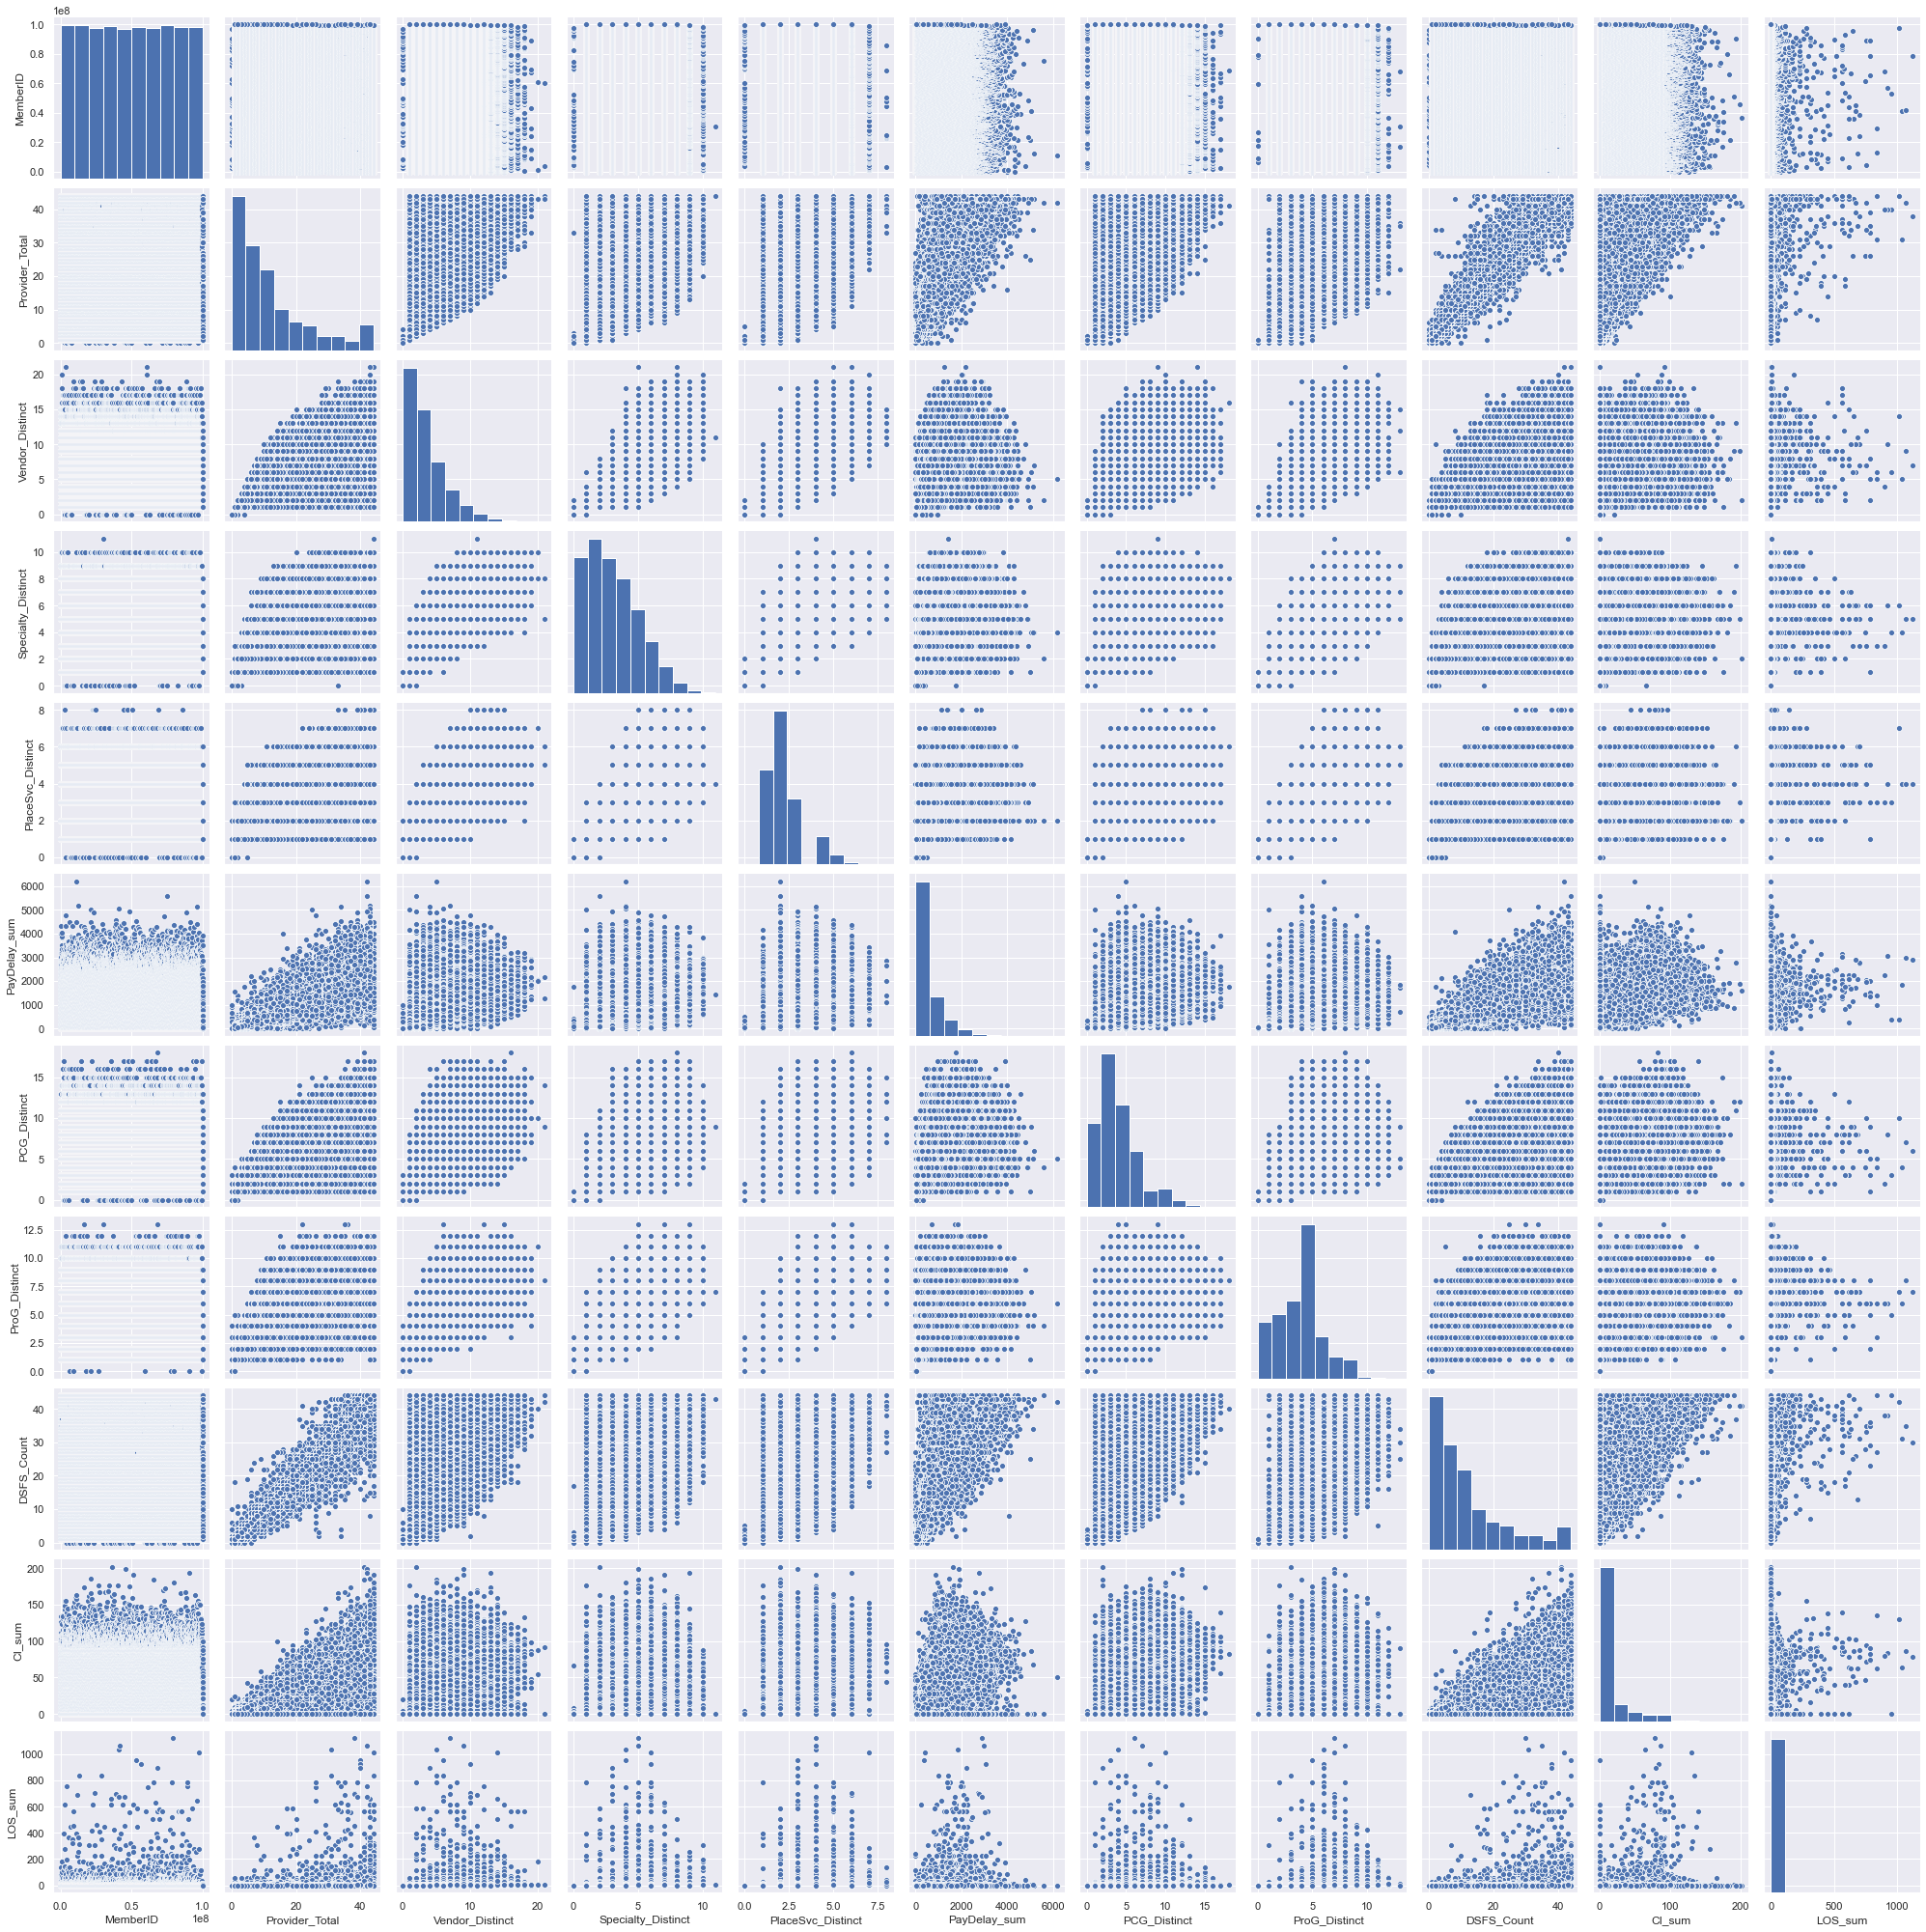

In [58]:
#Scatter plot của từng 
sns.set()
cols = ['MemberID','Year','Provider_Total','Vendor_Distinct','Specialty_Distinct','PlaceSvc_Distinct',
                        'PayDelay_sum','PCG_Distinct','ProG_Distinct','DSFS_Count','CI_sum','LOS_sum']
sns.pairplot(claims_byYear[cols], height = 2.5)
plt.show();

#Có 1 số biến có mối quan hệ linear với nhau
# Provider_Total vs Vendor, PayDelay, PCG,DSFS, CI có 1 đường plot line mà hầu hết các điểm đồ thị đều nằm trên đường đó.
# Provider cũng có uptrend với LOS

# Chúng ta nhìn được 1 số tác động của các biến categorical ban đầu:

#PrimaryConditionGroup, Specialty, PlaceSvc, Procedure có ảnh hưởng lên LOS
#Qua việc distinct count chúng ta cũng biết một memberID sẽ có nhiều Condition, nhiều Specialty, PlaceSvc, Procedure
#Câu hỏi đặt ra là làm sao xem được 1 member bị những bệnh gì, bao nhiêu lần, sử dụng các liệu pháp gì, ở đâu và theo từng năm

In [82]:
claims.Specialty.value_counts()

Internal                     672059
Laboratory                   653188
General Practice             473655
Surgery                      208217
Diagnostic Imaging           207297
Emergency                    126130
Other                         92687
Pediatrics                    84862
Rehabilitation                57554
Obstetrics and Gynecology     36594
Anesthesiology                33435
Pathology                     14907
Name: Specialty, dtype: int64

In [83]:
# thêm các cột detail trong bảng claims_byYear
# Specialty
claims_byYear['sp1_Int'] = claims_group['Specialty'].transform(lambda x: sum(x=='Internal'))
claims_byYear['sp2_Lab'] = claims_group['Specialty'].transform(lambda x: sum(x=='Laboratory'))
claims_byYear['sp3_Prac'] = claims_group['Specialty'].transform(lambda x: sum(x=='General Practice'))
claims_byYear['sp4_Sur'] = claims_group['Specialty'].transform(lambda x: sum(x=='Surgery'))
claims_byYear['sp5_DiIma'] = claims_group['Specialty'].transform(lambda x: sum(x=='Diagnostic Imaging'))
claims_byYear['sp6_Emer'] = claims_group['Specialty'].transform(lambda x: sum(x=='Emergency'))
claims_byYear['sp7_Other'] = claims_group['Specialty'].transform(lambda x: sum(x=='Other'))
claims_byYear['sp8_Pedia'] = claims_group['Specialty'].transform(lambda x: sum(x=='Pediatrics'))
claims_byYear['sp9_Rehab'] = claims_group['Specialty'].transform(lambda x: sum(x=='Rehabilitation'))
claims_byYear['sp10_Obs'] = claims_group['Specialty'].transform(lambda x: sum(x=='Obstetrics and Gynecology'))
claims_byYear['sp11_Anes'] = claims_group['Specialty'].transform(lambda x: sum(x=='Anesthesiology'))
claims_byYear['sp12_Path'] = claims_group['Specialty'].transform(lambda x: sum(x=='Pathology'))
claims_byYear['sp13_null'] = claims_group['Specialty'].transform(lambda x: sum(x.isnull()))

In [48]:
claims.PrimaryConditionGroup.value_counts()

MSC2a3      507277
METAB3      320553
ARTHSPIN    288285
NEUMENT     171605
RESPR4      138062
MISCHRT     131047
SKNAUT      107976
GIBLEED     101846
INFEC4       83552
TRAUMA       72050
HEART2       54207
RENAL3       52214
ROAMI        48821
MISCL5       48307
ODaBNCA      46732
UTI          44806
COPD         44154
GYNEC1       44143
CANCRB       42895
FXDISLC      40851
AMI          34805
PRGNCY       32004
HEMTOL       31631
HEART4       28733
SEIZURE      20501
APPCHOL      17945
CHF          13316
GYNECA       12491
PNEUM        11333
RENAL2       10922
GIOBSENT      9718
STROKE        8416
CANCRA        5587
FLaELEC       5263
MISCL1        4892
HIPFX         4355
METAB1        3863
PERVALV       3518
LIVERDZ       2747
CATAST        2070
CANCRM        1096
PERINTL        980
PNCRDZ         912
RENAL1         602
SEPSIS         497
Name: PrimaryConditionGroup, dtype: int64

In [84]:
#PrimaryConditionGroup
claims_byYear['pgc1_MSC2a3'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='MSC2a3'))
claims_byYear['pgc2_METAB3'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='METAB3'))
claims_byYear['pgc3_ARTHSPIN'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='ARTHSPIN'))
claims_byYear['pgc4_NEUMENT'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='NEUMENT'))
claims_byYear['pgc5_RESPR4'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='RESPR4'))
claims_byYear['pgc6_MISCHRT'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='MISCHRT'))
claims_byYear['pgc7_SKNAUT'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='SKNAUT'))
claims_byYear['pgc8_GIBLEED'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='GIBLEED'))
claims_byYear['pgc9_INFEC4'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='INFEC4'))
claims_byYear['pgc10_TRAUMA'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='TRAUMA'))
claims_byYear['pgc11_HEART2'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='HEART2'))
claims_byYear['pgc12_RENAL3'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='RENAL3'))
claims_byYear['pgc13_ROAMI'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='ROAMI'))
claims_byYear['pgc14_MISCL5'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='MISCL5'))
claims_byYear['pgc15_ODaBNCA'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='ODaBNCA'))
claims_byYear['pgc16_UTI'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='UTI'))
claims_byYear['pgc17_COPD'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='COPD'))
claims_byYear['pgc18_GYNEC1'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='GYNEC1'))
claims_byYear['pgc19_CANCRB'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='CANCRB'))
claims_byYear['pgc20_FXDISLC'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='FXDISLC'))
claims_byYear['pgc21_AMI'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='AMI'))
claims_byYear['pgc22_PRGNCY'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='PRGNCY'))
claims_byYear['pgc23_HEMTOL'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='HEMTOL'))
claims_byYear['pgc24_HEART4'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='HEART4'))
claims_byYear['pgc25_SEIZURE'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='SEIZURE'))
claims_byYear['pgc26_APPCHOL'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='APPCHOL'))
claims_byYear['pgc27_CHF'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='CHF'))
claims_byYear['pgc28_GYNECA'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='GYNECA'))
claims_byYear['pgc29_PNEUM'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='PNEUM'))
claims_byYear['pgc30_RENAL2'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='RENAL2'))
claims_byYear['pgc31_GIOBSENT'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='GIOBSENT'))
claims_byYear['pgc32_STROKE'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='STROKE'))
claims_byYear['pgc33_CANCRA'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='CANCRA'))
claims_byYear['pgc34_FLaELEC'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='FLaELEC'))
claims_byYear['pgc35_MISCL1'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='MISCL1'))
claims_byYear['pgc36_HIPFX'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='HIPFX'))
claims_byYear['pgc37_METAB1'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='METAB1'))
claims_byYear['pgc38_PERVALV'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='PERVALV'))
claims_byYear['pgc39_LIVERDZ'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='LIVERDZ'))
claims_byYear['pgc40_CATAST'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='CATAST'))
claims_byYear['pgc41_CANCRM'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='CANCRM'))
claims_byYear['pgc42_PERINTL'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='PERINTL'))
claims_byYear['pgc43_PNCRDZ'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='PNCRDZ'))
claims_byYear['pgc44_RENAL1'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='RENAL1'))
claims_byYear['pgc45_SEPSIS'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x=='SEPSIS'))
claims_byYear['pgc46_NULL'] = claims_group['PrimaryConditionGroup'].transform(lambda x: sum(x.isnull()))

In [49]:
claims.ProcedureGroup.value_counts()

EM      1048210
PL       492919
MED      372101
SCS      274805
RAD      265272
SDS       60678
SIS       56461
SMS       29177
ANES      17061
SGS        9406
SEOA       8420
SRS        7905
SNS        7796
SAS        5745
SUS        5612
SMCD       3376
SO          371
Name: ProcedureGroup, dtype: int64

In [85]:
#Procedure Group
claims_byYear['pg1_EM'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='EM'))
claims_byYear['pg2_PL'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='PL'))
claims_byYear['pg3_MED'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='MED'))                                                                 
claims_byYear['pg4_SCS'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SCS'))
claims_byYear['pg5_RAD'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='RAD'))
claims_byYear['pg6_SDS'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SDS'))
claims_byYear['pg7_SIS'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SIS'))
claims_byYear['pg8_SMS'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SMS'))                                                                 
claims_byYear['pg9_ANES'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='ANES'))
claims_byYear['pg10_SGS'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SGS'))
claims_byYear['pg11_SEOA'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SEOA'))
claims_byYear['pg12_SRS'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SRS'))
claims_byYear['pg13_SNS'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SNS'))                                                                 
claims_byYear['pg14_SAS'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SAS'))
claims_byYear['pg15_SUS'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SUS'))
claims_byYear['pg16_SMCD'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SMCD'))
claims_byYear['pg17_SO'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x=='SO'))
claims_byYear['pg18_NULL'] = claims_group['ProcedureGroup'].transform(lambda x: sum(x.isnull()))

In [50]:
claims.PlaceSvc.value_counts()

Office                 1542007
Independent Lab         657750
Urgent Care             199528
Outpatient Hospital     121528
Inpatient Hospital       85776
Ambulance                34766
Other                    11700
Home                      8303
Name: PlaceSvc, dtype: int64

In [86]:
claims_byYear['ps1_Off'] = claims_group['PlaceSvc'].transform(lambda x: sum(x=='Office'))                   
claims_byYear['ps2_ILab'] = claims_group['PlaceSvc'].transform(lambda x: sum(x=='Independent Lab'))                                             
claims_byYear['ps3_URC'] = claims_group['PlaceSvc'].transform(lambda x: sum(x=='Urgent Care'))                                                             
claims_byYear['ps4_OUT'] = claims_group['PlaceSvc'].transform(lambda x: sum(x=='Outpatient Hospital'))                                                                
claims_byYear['ps5_IN'] = claims_group['PlaceSvc'].transform(lambda x: sum(x=='Inpatient Hospital'))                                                                 
claims_byYear['ps6_AMBU'] = claims_group['PlaceSvc'].transform(lambda x: sum(x=='Ambulance'))                                                                 
claims_byYear['ps7_OTHER'] = claims_group['PlaceSvc'].transform(lambda x: sum(x=='Other'))                                                                 
claims_byYear['ps8_HOME'] = claims_group['PlaceSvc'].transform(lambda x: sum(x=='Home'))                                                                 
claims_byYear['ps9'] = claims_group['PlaceSvc'].transform(lambda x: sum(x.isnull()))

In [87]:
claims_byYear.head()

,MemberID,Year,Provider_Total,Provider_Distinct,Vendor_Distinct,PCP_Distinct,Specialty_Distinct,PlaceSvc_Distinct,PayDelay_sum,PayDelay_max,PayDelay_min,PCG_Distinct,ProG_Distinct,DSFS_Count,DSFS_max,DSFS_min,CI_sum,CI_max,CI_min,LOS_sum,LOS_max,LOS_min,sp1_Int,sp2_Lab,sp3_Prac,sp4_Sur,sp5_DiIma,sp6_Emer,sp7_Other,sp8_Pedia,sp9_Rehab,sp10_Obs,sp11_Anes,sp12_Path,sp13_null,pgc1_MSC2a3,pgc2_METAB3,pgc3_ARTHSPIN,pgc4_NEUMENT,pgc5_RESPR4,pgc6_MISCHRT,pgc7_SKNAUT,pgc8_GIBLEED,pgc9_INFEC4,pgc10_TRAUMA,pgc11_HEART2,pgc12_RENAL3,pgc13_ROAMI,pgc14_MISCL5,pgc15_ODaBNCA,pgc16_UTI,pgc17_COPD,pgc18_GYNEC1,pgc19_CANCRB,pgc20_FXDISLC,pgc21_AMI,pgc22_PRGNCY,pgc23_HEMTOL,pgc24_HEART4,pgc25_SEIZURE,pgc26_APPCHOL,pgc27_CHF,pgc28_GYNECA,pgc29_PNEUM,pgc30_RENAL2,pgc31_GIOBSENT,pgc32_STROKE,pgc33_CANCRA,pgc34_FLaELEC,pgc35_MISCL1,pgc36_HIPFX,pgc37_METAB1,pgc38_PERVALV,pgc39_LIVERDZ,pgc40_CATAST,pgc41_CANCRM,pgc42_PERINTL,pgc43_PNCRDZ,pgc44_RENAL1,pgc45_SEPSIS,pgc46_NULL,pg1_EM,pg2_PL,pg3_MED,pg4_SCS,pg5_RAD,pg6_SDS,pg7_SIS,pg8_SMS,pg9_ANES,pg10_SGS,pg11_SEOA,pg12_SRS,pg13_SNS,pg14_SAS,pg15_SUS,pg16_SMCD,pg17_SO,pg18_NULL,ps1_Off,ps2_ILab,ps3_URC,ps4_OUT,ps5_IN,ps6_AMBU,ps7_OTHER,ps8_HOME,ps9
0,4,Y2,1,1,1,1,1,1,43,43,43,1,1,1,1.000,1.000,0,0,0,0.000,nan,nan,4,2,1,3,0,0,1,0,0,0,0,0,1,2,2,1,3,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2,0,1,0,0,0,0,0
1,210,Y1,8,4,4,2,3,3,720,162,22,4,5,8,7.000,0.000,0,0,0,2.000,2.000,2.000,22,7,0,5,1,0,6,0,0,0,2,1,0,7,6,0,6,0,5,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,17,8,11,3,3,1,0,0,1,0,0,0,0,0,0,0,0,0,30,7,0,7,0,0,0,0,0
2,210,Y2,6,3,3,1,3,2,308,128,31,2,3,6,7.000,0.000,0,0,0,0.000,nan,nan,1,2,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0
3,210,Y3,4,2,2,1,2,2,143,44,23,2,2,4,7.000,1.000,0,0,0,0.000,nan,nan,8,15,0,2,3,0,0,0,0,2,0,0,0,3,13,5,0,5,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,9,1,6,3,0,0,1,0,0,0,0,0,0,0,0,0,0,15,15,0,0,0,0,0,0,0
4,3197,Y1,5,3,3,1,2,2,492,162,36,2,2,5,12.000,1.000,0,0,0,0.000,nan,nan,13,8,8,12,1,0,1,0,0,0,0,0,0,17,2,2,0,2,1,0,0,0,0,0,0,0,0,0,0,4,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,4,4,4,13,0,0,0,0,0,0,0,0,0,0,0,0,0,10,8,0,25,0,0,0,0,0


In [88]:
claims_byYear.to_csv("claims_byYear2.csv", index=False)